In [2]:
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from google.colab import files
from numpy import diff
from scipy import integrate
import time
Lx,Ly = 4*math.pi,4*math.pi
#Lx,Ly = 6e4,6e4                                     # Space in x and y direction likewise Lx and Ly are described to be 4pi (-2pi,2pi) grid
Nx = 513                                            # Grid points in x direction initial number of grid points is based upon 256x256 box
Ny = 513                                            # Grid points in z direction

#r = (0.5/(4*math.pi)) * Lx                          # Radius is described to be R = 0.5 which I assume is scaled to the reference point 4*math.pi

r = 0.5
d_1 = 3.2 * r                                       # 1st test case is when d/r = 3.2 so d = 3.2 * r
dc_1 = 2 * r                                        # distance from the shelf is dc/r = 2 so dc = 2 * r

d_2 = 3.8 * r                                       # 2nd test case is when  d/r = 3.8
dc_2 = r                                            # distance from the shelf is dc/r = 1 so dc = r

d_3 = 4 * r                                         # 3rd test case with anticylones d/r = 4
dc_3 = 3 * r                                        # distance from the shelf is dc/r = 3 so dc = 3r

#vx = (6.67e-6)/ math.sqrt(2)
#print(vx)
# Nx = 101                                            # Grid points in x direction
# Ny = 51                                            # Grid points in z direction
# dx,dy = 200000,200000
# Lx = dx*(Nx-1)
# Ly = dy*(Ny-1)
tol = 8e-9                                          # Tolerance = 10^-7
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
print(dx)
print(dy)
# T_tot = 3 * 24 * 60 * 60                            # T_total = 3 days

T_tot = 30                                  # T_total = 4 * 10^4

# The decision to make delta_t = 320 was to satisfy the courant condition as V_max = 0.4 which means
#Vx and Vy max would be ~0.282 respectively dx and dy are equivalent at 234.375 m and so
# 0.282*delta_t/dx + 0.282*delta_t/dy <= 1
# Solving for delta t we get ~415.55 seconds and to be safe I multiplied 0.8 * this value
# to get 332 and instead I just made it 320 seconds to be safe which is 125 time steps

# Using the condition that w / f0 = 0.5 and that the estimate for w holds the relationship 2v/r = w
# I deduced the delta_t by solving for v and finding the largest values of vx and vy that delta t
#would need to satisfy CFL condition

delta_t = 0.01                                        # The decision to make delta_t = 320 was to satisfy the courant condition as V_max = 0.4 which means Vx and Vy max would be 0.282 respectively

# x = np.linspace(0,Nx,Nx)
# y = np.linspace(0,Ny,Ny)

x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
x_mesh,y_mesh = np.meshgrid(x,y)

# f_0 = 10e-4
# Rd = 287.053
# Ts = 297
# a = -5e6
# b = 7.5e8

g = 9.81
f0 = 2
#f0 = 5.4e-5                                        # f_0 is described as 5.4 * 10^-5
H = 1
# Rd = 287.053                                        # Sticking to definition of Rd as 287.053 * J * kg / K
# Ts = 297                                        #
v_art  = 1.5e-3

#tau = 8.413 /(math.pi * r**2)
#vort_function = lambda x, y, x0, y0:tau*  np.exp(-1*((((x - x0) ** 2) / (r ** 2)) + (((y - y0) ** 2) / (r ** 2))))
#scaling_factor = Lx/(4*math.pi)


0.02454369260617026
0.02454369260617026


In [3]:
def vort_function(x, y, x0, y0):
    dist_squared = (x - x0)**2 + (y - y0)**2
    return np.where(dist_squared <= r**2, 1.0, 0.0)


In [4]:
def vort_function_anti(x, y, x0, y0):
    dist_squared = (x - x0)**2 + (y - y0)**2
    return np.where(dist_squared <= r**2, -1.0, 0.0)


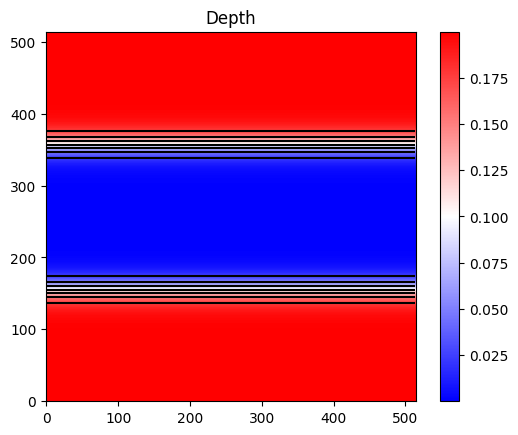

In [5]:
def depth_function_cyc():
  depth = np.zeros([Nx+2,Ny+2])
  H = 1
  hb_0 = 0.2 * H
  yt = 2.5/(4*math.pi) * Ny-1
  Lt = 0.5/(4*math.pi) * Ny-1
  f = (Ny-1)/2
  for j in range (1,Ny+1):
    if j == Ny:
      depth[Ny+1,:] = depth[2,:]
    for i in range (1,Nx+1):
      if i == Nx:
        depth[j,Nx+1] = depth[j,2]

      depth[j,i] = hb_0*((1.0 + 0.5 * math.tanh(((j-f) - yt)/Lt) - 0.5 * math.tanh(((j-f) + yt)/Lt)))
      depth[j,0] = depth[j,Nx-1]
    depth[0,:] = depth[Ny-1,:]
  return depth

depth = depth_function_cyc()
plot_cmap(depth,"Depth")

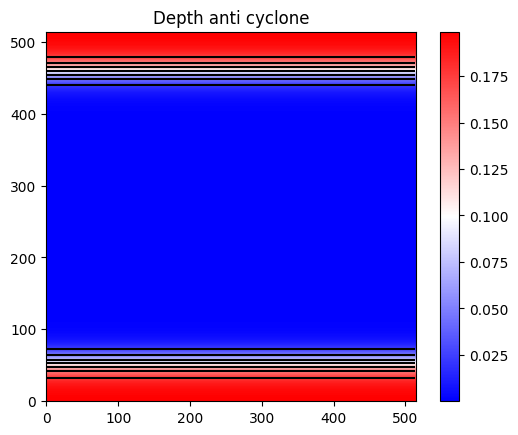

In [6]:
def depth_function_anticyc():
  depth = np.zeros([Nx+2,Ny+2])
  H = 1
  hb_0 = 0.2 * H
  yt = 5.0/(4*math.pi) * (Ny-1)
  Lt = 0.5/(4*math.pi) * (Ny-1)
  f = (Ny-1)/2
  for j in range (1,Ny+1):
    if j == Ny:
      depth[Ny+1,:] = depth[2,:]
    for i in range (1,Nx+1):
      if i == Nx:
        depth[j,Nx+1] = depth[j,2]

      depth[j,i] = hb_0*((1.0 + 0.5 * math.tanh(((j-f) - yt)/Lt) - 0.5 * math.tanh(((j-f) + yt)/Lt)))
      depth[j,0] = depth[j,Nx-1]
    depth[0,:] = depth[Ny-1,:]
  return depth

depth_anti = depth_function_anticyc()
plot_cmap(depth_anti,"Depth anti cyclone")

In [7]:
def calc_vort_coord(d,dc):
  x1 = Lx/2 - d/2                   # Start from the center and move left half the distance
  x2 = Lx/2 + d/2                   # Start from the center and move right half the distance
  y = Ly/4 + dc + r                 # Shelf is located at 1 pi (-1pi) so if we add the distance r we essentially move up by that amount Note we are adding 1 r already to offset it to match the paper.
  return x1,x2,y

In [8]:
def calc_vort_coord3(d,dc):
  x1 = Lx/2 - d/2                   # Start from the center and move left half the distance
  x2 = Lx/2 + d/2                   # Start from the center and move right half the distance
  y = Ly/8 + dc                  # Shelf is located at 1/2 pi (-1pi) so if we add the distance r we essentially move up by that amount Note we are adding 1 r already to offset it to match the paper.
  return x1,x2,y

In [9]:

# A = 1500.0
# sigma_x = 4.0
# sigma_y = 7.0
# z = np.zeros([Ny,Nx])
# for j in range (0,Ny):
#   for i in range(0,Nx):
#     z[j,i] = A * math.exp(-1 * (((i-50.0)**2)/(2.0*(sigma_x**2)))) * math.exp(-1*(((j-25.0)**2)/(2.0*(sigma_y**2))))

In [10]:
# init_psi = np.zeros([Ny+2,Nx+2])

# for j in range (1,Ny+1):
#   if j == Ny:
#     init_psi[Ny+1,:] = init_psi[2,:]
#   for i in range(1,Nx+1):
#     if i == Nx:
#       init_psi[j,Nx+1] = init_psi[j,2]

#     init_psi[j,i] = a * j + b

#     init_psi[j,0] = init_psi[j,Nx-1]
#   init_psi[0,:] = init_psi[Ny-1,:]



In [11]:
def compute_laplacian(psi):
    vort = np.zeros([Ny+2,Nx+2])
    for j in range (1,Ny+1):
      if j == Ny:
        vort[Ny+1,:] = vort[2,:]
      for i in range (1,Nx+1):
        if i == Nx:
          vort[j,Nx+1] = vort[j,2]

        vort[j,i] = ((psi[j,i+1] + psi[j,i-1] + psi[j+1,i] + psi[j-1,i] - 4 * psi[j,i])/(dx**2) )
      vort[j,0] = vort[j,Nx-1]
    vort[0,:] = vort[Ny-1,:]

    # vort[:,1] = 0
    # vort[:,Nx] = 0
    # vort[Ny,:] = 0
    # vort[1,:] = 0

    vort[0,:] = vort[Ny-1,:]
    vort[Ny+1,:] = vort[2,:]

    vort[:,Nx+1] = vort[:,2]
    vort[:,0] = vort[:,Nx-1]

    return vort

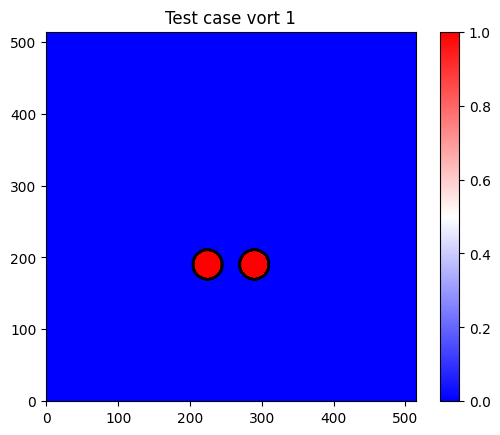

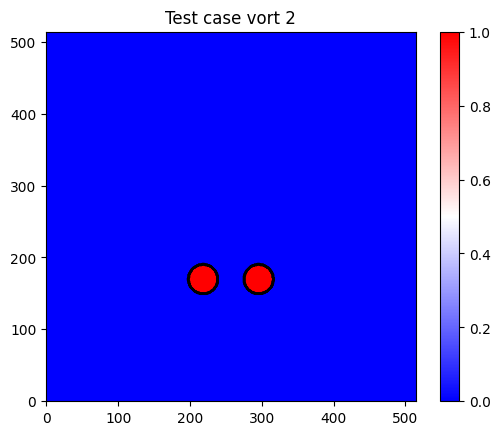

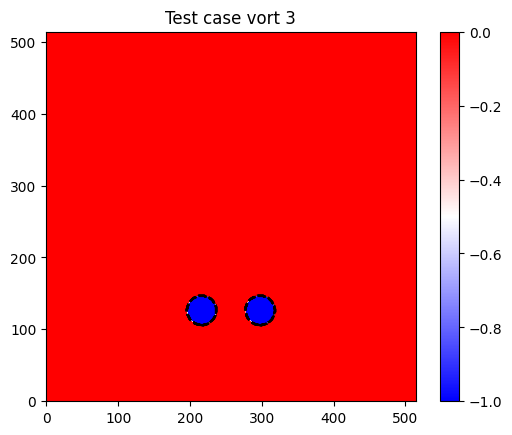

In [12]:
x_01,x_02,y_01 = calc_vort_coord(d_1,dc_1)
x_11,x_12,y_11 = calc_vort_coord(d_2,dc_2)
x_21,x_22,y_21 = calc_vort_coord3(d_3,dc_3)

vort_01 = np.zeros([Ny+2,Nx+2])
vort_02 = np.zeros([Ny+2,Nx+2])
vort_00 = np.zeros([Ny+2,Nx+2])

vort_01[1:Ny+1,1:Nx+1] = vort_function(x_mesh,y_mesh,x_01,y_01)
vort_02[1:Ny+1,1:Nx+1] = vort_function(x_mesh,y_mesh,x_02,y_01)
vort_00 = vort_01 + vort_02


vort_11 = np.zeros([Ny+2,Nx+2])
vort_12 = np.zeros([Ny+2,Nx+2])
vort_10 = np.zeros([Ny+2,Nx+2])

vort_11[1:Ny+1,1:Nx+1] = vort_function(x_mesh,y_mesh,x_11,y_11)
vort_12[1:Ny+1,1:Nx+1] = vort_function(x_mesh,y_mesh,x_12,y_11)
vort_10 = vort_11 + vort_12

vort_21 = np.zeros([Ny+2,Nx+2])
vort_22 = np.zeros([Ny+2,Nx+2])
vort_20 = np.zeros([Ny+2,Nx+2])

vort_21[1:Ny+1,1:Nx+1] = vort_function_anti(x_mesh,y_mesh,x_21,y_21)
vort_22[1:Ny+1,1:Nx+1] = vort_function_anti(x_mesh,y_mesh,x_22,y_21)
vort_20 = vort_21 + vort_22

plot_cmap(vort_00,"Test case vort 1")
plot_cmap(vort_10,"Test case vort 2")
plot_cmap(vort_20,"Test case vort 3")

In [13]:
def get_average(vort):
  sum_total = 0.0
  compensation = 0.0

  for value in np.nditer(vort):
    y = value - compensation
    temp = sum_total + y
    compensation = (temp - sum_total) - y
    sum_total = temp

  num_elements = vort.size
  average = sum_total/num_elements
  return average

def kahan_sum(average,vorticity):
  num_elements = vorticity.size

  while((average) > tol):
    print(average)
    vorticity = vorticity - average
    sum_total = 0.0
    compensation = 0.0

    for value in np.nditer(vorticity):
      y = value - compensation
      temp = sum_total + y
      compensation = (temp - sum_total) - y
      sum_total = temp


    average = sum_total/num_elements
    print(average)
    # print(vorticity)

  return vorticity

0.009833160524083326
-5.205249622476698e-19
0.009825619756810256
-6.831563100850279e-19


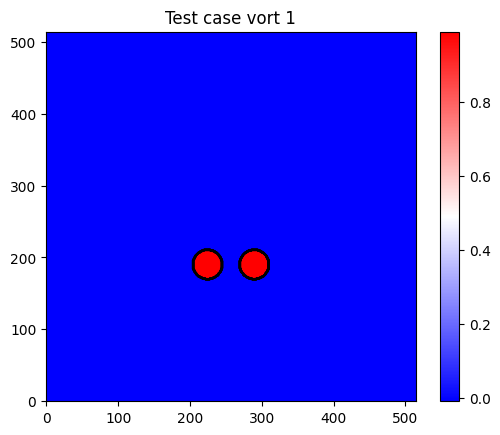

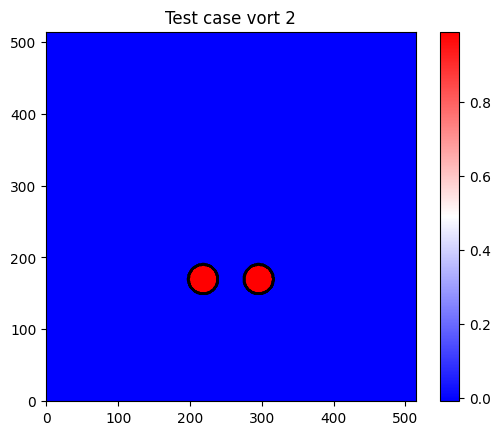

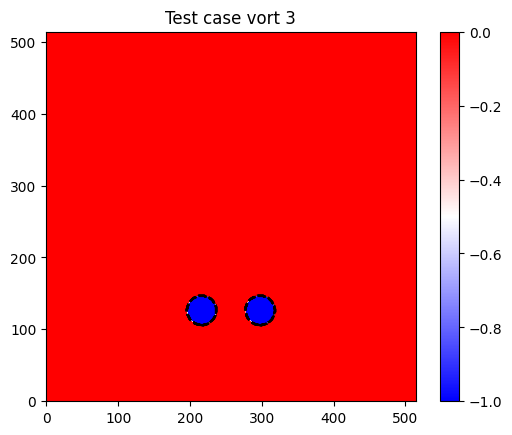

In [14]:
average_00 = get_average(vort_00)
average_01 = get_average(vort_10)
average_02 = get_average(vort_20)

vort_00 = kahan_sum(average_00,vort_00)
vort_10 = kahan_sum(average_01,vort_10)
vort_20 = kahan_sum(average_02,vort_20)

plot_cmap(vort_00,"Test case vort 1")
plot_cmap(vort_10,"Test case vort 2")
plot_cmap(vort_20,"Test case vort 3")

In [15]:
def SOR_opt(dx,dy):
  sigma = (1/(1+(dx/dy)**2))*((math.cos(math.pi/Nx)+((dx/dy)**2))*(math.cos(math.pi/Ny)))
  return 2/(1+math.sqrt(1-sigma**2))

print(SOR_opt(dx,dy))

1.9851112615597986


In [16]:
def plot_cmap(np_array, Title):
    plt.figure()
    plt.imshow(np_array, cmap='bwr', vmin=np.min(np_array), vmax=np.max(np_array))
    plt.gca().invert_yaxis()  # Invert y-axis
    plt.colorbar()
    plt.contour(np_array,colors = 'black')
    plt.title(Title)
    plt.show()


In [17]:
def plot_cmap_z(np_array,z, Title):
    plt.figure()
    plt.imshow(np_array, cmap='bwr', vmin=np.min(np_array), vmax=np.max(np_array))
    plt.gca().invert_yaxis()  # Invert y-axis
    plt.colorbar()
    plt.contour(np_array, colors = 'lime',linewidths=0.4)
    plt.contour(z, colors = 'black')
    plt.title(Title)
    plt.show()

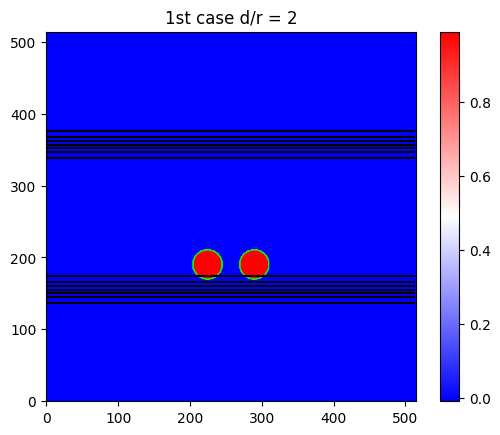

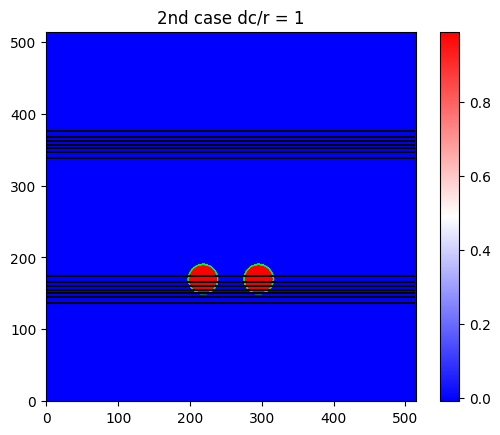

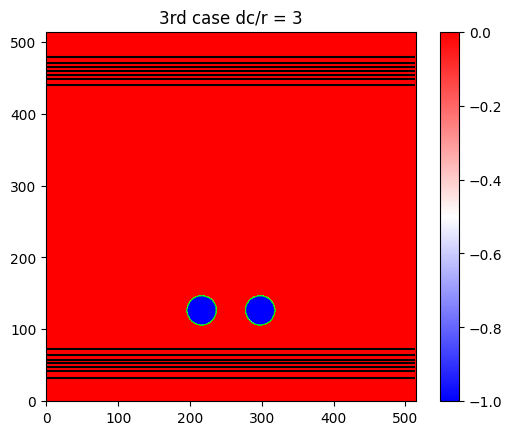

In [18]:
plot_cmap_z(vort_00,depth,"1st case d/r = 2")
plot_cmap_z(vort_10,depth,"2nd case dc/r = 1")
plot_cmap_z(vort_20,depth_anti,"3rd case dc/r = 3")

In [19]:
compute_laplacian

<function __main__.compute_laplacian(psi)>

In [20]:
                             # Setup vorticity field with periodic boundary conditions for x and walls for z
# psi = init_psi
# init_z = z
# plot_cmap(init_z,"Z color map")
# psi = init_psi
# plot_cmap(psi,"Initial Psi")
# vort_super = compute_laplacian(psi)
# plot_cmap(vort_super,"Vort")

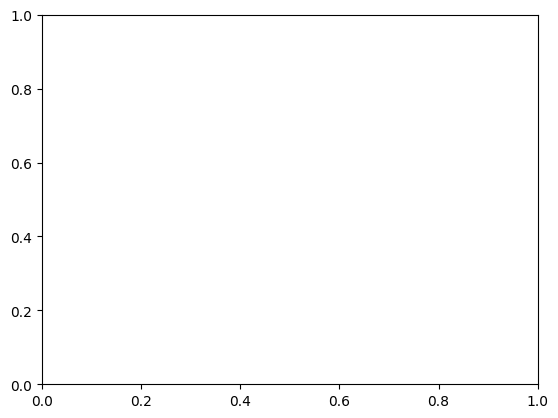

In [21]:

fig, ax = plt.subplots()

def animate(frame, u,v,t_delta):
    ax.clear()
    cmap = 'bwr'
    img = ax.imshow(u[frame, 1:Ny+1, 1:Nx+1],cmap=cmap, origin='lower', extent=[0, Lx, 0, Ly])

    linewidth = 0.5
    # Plot contour lines for array u
    u_contour = ax.contour(u[frame,1:Ny+1, 1:Nx+1], origin='lower',colors = 'lime',linewidths = linewidth, extent=[0, Lx, 0, Ly])
    ax.clabel(u_contour, inline=True, fontsize=8)

    # Plot contour lines for array v separately
    v_contour = ax.contour(v[1:Ny+1, 1:Nx+1], origin='lower',colors = 'black',linewidths = linewidth, extent=[0, Lx, 0, Ly])
    ax.clabel(v_contour, inline=True, fontsize=8)

    ax.set_title("Vorticity at time step: {0:.2f}".format(frame * t_delta))
    ax.set_xlim(0,Lx)
    ax.set_ylim(0,Ly)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    return [img]+u_contour.collections+v_contour.collections


In [22]:


def infinite_norm(matrix):
    return np.max(np.abs(matrix))

def one_norm(matrix):
    return np.sum(np.abs(matrix))

e_dxdy = 2/dx/dx + 2/dy/dy

def error(psi,vort,res):
  psi_one_norm = one_norm(psi)
  res_inf_norm = infinite_norm(res)
  vort_inf_norm = infinite_norm(vort)

  EPS = res_inf_norm /((e_dxdy)*psi_one_norm + vort_inf_norm)
  return EPS

In [23]:
def SOR(vort):
  psi = np.zeros([Ny+2,Nx+2])
  residual = np.zeros([Ny+2,Nx+2])
  u = np.zeros([Ny+2,Nx+2])
  v = np.zeros([Ny+2,Nx+2])
  coef = SOR_opt(dx,dy)


  residual[1:Ny+1,1:Nx+1] =  1/dx/dx *(psi[0:Ny,1:Nx+1] - 2*psi[1:Ny+1,1:Nx+1] + psi[2:Ny+2,1:Nx+1]) \
  + 1/dy/dy * (psi[1:Ny+1,0:Nx]-2*psi[1:Ny+1,1:Nx+1]+psi[1:Ny+1,2:Nx+2]) - vort[1:Ny+1,1:Nx+1]

  # residual[1,:] = 0
  # residual[Ny,:] = 0
  # residual[:,1] = 0
  # residual[:,Nx] = 0


  residual[0,:] = residual[Ny-1,:]
  residual[Ny+1,:] = residual[2,:]
  residual[:,0] = residual[:,Nx-1]
  residual[:,Nx+1] = residual[:,2]

  EPS = error(psi,vort,residual)
  num_iterations = 0
  EPS_arr = []
  EPS_arr.append(EPS)
  while(EPS >= tol):
    for j in range(1,Nx+1):
      if (j == Ny):
        residual[Ny+1,:] = residual[2,:]
        psi[Ny+1,:] = psi[2,:]
      for i in range(1,Nx+1):
        if(i == Nx):
          #update ghost nodes at Nx+1 at current j
          residual[j,Nx+1] = residual[j,2]
          psi[j,Nx+1] = psi[j,2]

        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dy/dy *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) - vort[j,i]

        psi[j,i] = psi[j,i] + coef/(e_dxdy) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma

      #update ghost nodes at i = 0 at current j
      residual[j,0] = residual[j,Nx-1]
      psi[j,0] = psi[j,Nx-1]

    residual[0,:] = residual[Ny-1,:]
    psi[0,:] = psi[Ny-1,:]
    EPS = error(psi,vort,residual)
    #print(EPS)
    num_iterations += 1
    EPS_arr.append(EPS)
  print("Number of poisson iterations: {}".format(num_iterations))
  # print(psi.shape)

  #calculate u and v bz differentating psi with respect to dy and dx
  # u, v = np.gradient(psi, dy, dx)
  u = np.gradient(psi,dy,axis = 0)
  v = np.gradient(psi,dx,axis = 1)
  # Multiplz d_psi_dy bz -1 to get the negative of the derivative
  u *= -1


  # Compute the Laplacian (∇²psi) using numerical differentiation
  d2_psi_dx2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dx**2
  d2_psi_dy2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dy**2

  laplacian_psi = d2_psi_dx2 + d2_psi_dy2

  return psi,u,v,num_iterations,laplacian_psi

In [24]:
def SOR_psi(psi,vort):
  residual = np.zeros([Ny+2,Nx+2])
  u = np.zeros([Ny+2,Nx+2])
  v = np.zeros([Ny+2,Nx+2])
  coef = SOR_opt(dx,dy)


  residual[1:Ny+1,1:Nx+1] =  1/dx/dx *(psi[0:Ny,1:Nx+1] - 2*psi[1:Ny+1,1:Nx+1] + psi[2:Ny+2,1:Nx+1]) \
   + 1/dy/dy * (psi[1:Ny+1,0:Nx]-2*psi[1:Ny+1,1:Nx+1]+psi[1:Ny+1,2:Nx+2]) - vort[1:Ny+1,1:Nx+1]


  # residual[1,:] = 0
  # residual[Ny,:] = 0
  # residual[:,1] = 0
  # residual[:,Nx] = 0
  residual[0,:] = residual[Ny-1,:]
  residual[Ny+1,:] = residual[2,:]
  residual[:,0] = residual[:,Nx-1]
  residual[:,Nx+1] = residual[:,2]

  EPS = error(psi,vort,residual)
  num_iterations = 0
  EPS_arr = []
  EPS_arr.append(EPS)
  while(EPS >= tol):
    for j in range(1,Ny+1):
      if (j == Ny):
        residual[Ny+1,:] = residual[2,:]
        psi[Ny+1,:] = psi[2,:]
      for i in range(1,Nx+1):
        if(i == Nx):
          #update ghost nodes at Nx+1 at current j
          residual[j,Nx+1] = residual[j,2]
          psi[j,Nx+1] = psi[j,2]

        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dy/dy *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) - vort[j,i]

        psi[j,i] = psi[j,i] + coef/(e_dxdy) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma

      #update ghost nodes at i = 0 at current j
      residual[j,0] = residual[j,Nx-1]
      psi[j,0] = psi[j,Nx-1]

    residual[0,:] = residual[Ny-1,:]
    psi[0,:] = psi[Ny-1,:]
    #print(EPS)
    EPS = error(psi,vort,residual)
    num_iterations += 1
    EPS_arr.append(EPS)
  print(num_iterations)
  # print(psi.shape)

  #calculate u and v bz differentating psi with respect to dy and dx
  # u, v = np.gradient(psi, dy, dx)
  u = np.gradient(psi,dy,axis = 0)
  v = np.gradient(psi,dx,axis = 1)
  # Multiplz d_psi_dy bz -1 to get the negative of the derivative
  u *= -1


  # Compute the Laplacian (∇²psi) using numerical differentiation
  d2_psi_dx2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dx**2
  d2_psi_dy2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dy**2

  laplacian_psi = d2_psi_dx2 + d2_psi_dy2

  return psi,u,v,num_iterations,laplacian_psi

In [25]:

# psi,u,v,num_iterations,laplacian_psi = SOR(vort_super)
# print(psi[0,:])
# Mg = np.sqrt(u**2+v**2)

ktot = lambda z,x :0.5*np.sqrt(u**2+v**2)**2
def ktot(u,v):
  return 0.5*np.sqrt(u**2+v**2)**2

def double_Integral(xmin, xmax, zmin, zmax, nx, Ny, A):

    dS = ((xmax-xmin)/(nx-1)) * ((zmax-zmin)/(Ny-1))

    A_Internal = A[1:-1, 1:-1]

    # sides: up, down, left, right
    (A_u, A_d, A_l, A_r) = (A[0, 1:-1], A[-1, 1:-1], A[1:-1, 0], A[1:-1, -1])

    # corners
    (A_ul, A_ur, A_dl, A_dr) = (A[0, 0], A[0, -1], A[-1, 0], A[-1, -1])

    return dS * (np.sum(A_Internal)\
                + 0.5 * (np.sum(A_u) + np.sum(A_d) + np.sum(A_l) + np.sum(A_r))\
                + 0.25 * (A_ul + A_ur + A_dl + A_dr))


# Derived from doing max(u/dx + v/dy)
def courant_max(u, v, delta_t):
    return np.max(np.abs(u) * delta_t / dx + np.abs(v) * delta_t / dy)



In [26]:
def Arakawa_desc(psi,vort,temp):
  J_arakawa_vort = np.zeros([Ny+2,Nx+2])
  J_arakawa_temp = np.zeros([Ny+2,Nx+2])

  J = np.zeros([Ny+2,Nx+2])
  J_hat = np.zeros([Ny+2,Nx+2])
  J_tilda = np.zeros([Ny+2,Nx+2])

  J_temp = np.zeros([Ny+2,Nx+2])
  J_hat_temp = np.zeros([Ny+2,Nx+2])
  J_tilda_temp = np.zeros([Ny+2,Nx+2])
  # for i in range(1,N)
  for z in range(2,Ny):
    for i in range(1,Nx+1):

      J[z,i] = (1/(4*dx*dy))*((psi[z,i+1] - psi[z,i-1]) * (vort[z+1,i] - vort[z-1,i])
      - (psi[z+1,i] - psi[z-1,i]) * (vort[z,i+1] - vort[z,i-1]))

      J_hat[z,i] = (1/(4*dx*dy))* (((psi[z,i+1])*(vort[z+1,i+1] - vort[z-1,i+1])) \
      - ((psi[z,i-1])*(vort[z+1,i-1] - vort[z-1,i-1]))  \
      - ((psi[z+1,i])*(vort[z+1,i+1] - vort[z+1,i-1]))  \
      + ((psi[z-1,i])*(vort[z-1,i+1] - vort[z-1,i-1])))

      J_tilda[z,i] = (1/(4*dx*dy))* (((vort[z+1,i])*(psi[z+1,i+1] - psi[z+1,i-1])) \
      - ((vort[z-1,i])*(psi[z-1,i+1] - psi[z-1,i-1]))  \
      - ((vort[z,i+1])*(psi[z+1,i+1] - psi[z-1,i+1]))  \
      + ((vort[z,i-1])*(psi[z+1,i-1] - psi[z-1,i-1])))

      # J_arakawa_vort = (J + J_hat + J_tilda)/3


      J_temp[z,i] = (1/(4*dx*dy))*((psi[z,i+1] - psi[z,i-1]) * (temp[z+1,i] - temp[z-1,i])
      - (psi[z+1,i] - psi[z-1,i]) * (temp[z,i+1] - temp[z,i-1]))

      J_hat_temp[z,i] = (1/(4*dx*dy))* (((psi[z,i+1])*(temp[z+1,i+1] - temp[z-1,i+1])) \
      - ((psi[z,i-1])*(temp[z+1,i-1] - temp[z-1,i-1]))  \
      - ((psi[z+1,i])*(temp[z+1,i+1] - temp[z+1,i-1]))  \
      + ((psi[z-1,i])*(temp[z-1,i+1] - temp[z-1,i-1])))

      J_tilda_temp[z,i] = (1/(4*dx*dy))* (((temp[z+1,i])*(psi[z+1,i+1] - psi[z+1,i-1])) \
      - ((temp[z-1,i])*(psi[z-1,i+1] - psi[z-1,i-1]))  \
      - ((temp[z,i+1])*(psi[z+1,i+1] - psi[z-1,i+1]))  \
      + ((temp[z,i-1])*(psi[z+1,i-1] - psi[z-1,i-1])))

  J_arakawa_vort = (J + J_hat + J_tilda) / 3
  J_arakawa_temp = (J_temp + J_hat_temp + J_tilda_temp)/3

  return J_arakawa_vort,J_arakawa_temp


In [27]:

def Final_Simulation(t_delta,init_vort,init_z):
  t_steps = int(T_tot/t_delta)
  psi,u,v,num_iterations,laplacian_psi=SOR(init_vort)
  #psi = init_psi
  vort = np.zeros([t_steps,Ny+2,Nx+2])
  vort[0,:,:] = init_vort
  z = np.zeros([Ny+2,Nx+2])
  z = init_z



  C_max_arr = []
  num_iterations_arr = []
  k_energy_arr = []
  #Append num_iterations
  num_iterations_arr.append(num_iterations)

  #Calculate Von Neumann
  C_max = courant_max(u,v,t_delta)
  C_max_arr.append(C_max)
  print("Von Neumman:{}".format(C_max))


  #Calculate new vorticity using FTCS for first time step using implied loops from 1 to Nx-1 and 1 to Ny-1 grid points

  J_arakawa_vort = np.zeros([Ny+2,Nx+2])
  J_arakawa_z = np.zeros([Ny+2,Nx+2])

  J = (1/(4*dx*dy))*((psi[1:Ny+1,2:Nx+2] - psi[1:Ny+1,0:Nx]) * (vort[0,2:Ny+2,1:Nx+1] - vort[0,0:Ny,1:Nx+1])
  - (psi[2:Ny+2,1:Nx+1] - psi[0:Ny,1:Nx+1]) * (vort[0,1:Ny+1,2:Nx+2] - vort[0,1:Ny+1,0:Nx]))

  J_hat = (1/(4*dx*dy))* (((psi[1:Ny+1,2:Nx+2])*(vort[0,2:Ny+2,2:Nx+2] - vort[0,0:Ny,2:Nx+2])) \
  - ((psi[1:Ny+1,0:Nx])*(vort[0,2:Ny+2,0:Nx] - vort[0,0:Ny,0:Nx]))  \
  - ((psi[2:Ny+2,1:Nx+1])*(vort[0,2:Ny+2,2:Nx+2] - vort[0,2:Ny+2,0:Nx]))  \
  + ((psi[0:Ny,1:Nx+1])*(vort[0,0:Ny,2:Nx+2] - vort[0,0:Ny,0:Nx])))

  J_tilda = (1/(4*dx*dy))* (((vort[0,2:Ny+2,1:Nx+1])*(psi[2:Ny+2,2:Nx+2] - psi[2:Ny+2,0:Nx])) \
  - ((vort[0,0:Ny,1:Nx+1])*(psi[0:Ny,2:Nx+2] - psi[0:Ny,0:Nx]))  \
  - ((vort[0,1:Ny+1,2:Nx+2])*(psi[2:Ny+2,2:Nx+2] - psi[0:Ny,2:Nx+2]))  \
  + ((vort[0,1:Ny+1,0:Nx])*(psi[2:Ny+2,0:Nx] - psi[0:Ny,0:Nx])))


  J_arakawa_vort[1:Ny+1,1:Nx+1] = (J + J_hat + J_tilda) / 3

  J_z = (1/(4*dx*dy))*((psi[1:Ny+1,2:Ny+2] - psi[1:Ny+1,0:Nx]) * (z[2:Ny+2,1:Nx+1] - z[0:Ny,1:Nx+1])
  - (psi[2:Ny+2,1:Nx+1] - psi[0:Ny,1:Nx+1]) * (z[1:Ny+1,2:Nx+2] - z[1:Ny+1,0:Nx]))

  J_hat_z = (1/(4*dx*dy))* (((psi[1:Ny+1,2:Nx+2])*(z[2:Ny+2,2:Nx+2] - z[0:Ny,2:Nx+2])) \
  - ((psi[1:Ny+1,0:Nx])*(z[2:Ny+2,0:Nx] - z[0:Ny,0:Nx]))  \
  - ((psi[2:Ny+2,1:Nx+1])*(z[2:Ny+2,2:Nx+2] - z[2:Ny+2,0:Nx]))  \
  + ((psi[0:Ny,1:Nx+1])*(z[0:Ny,2:Nx+2] - z[0:Ny,0:Nx])))

  J_tilda_z = (1/(4*dx*dy))* (((z[2:Ny+2,1:Nx+1])*(psi[2:Ny+2,2:Nx+2] - psi[2:Ny+2,0:Nx])) \
  - ((z[0:Ny,1:Nx+1])*(psi[0:Ny,2:Nx+2] - psi[0:Ny,0:Nx]))  \
  - ((z[1:Ny+1,2:Nx+2])*(psi[2:Ny+2,2:Nx+2] - psi[0:Ny,2:Nx+2]))  \
  + ((z[1:Ny+1,0:Nx])*(psi[2:Ny+2,0:Nx] - psi[0:Ny,0:Nx])))

  J_arakawa_z[1:Ny+1,1:Nx+1] = (J_z + J_hat_z + J_tilda_z)/3

  visc = compute_laplacian(vort[0,:,:])
  vort[1,1:Ny+1,1:Nx+1] = vort[0,1:Ny+1,1:Nx+1] + (2*t_delta)*((v_art * visc[1:Ny+1,1:Nx+1])-J_arakawa_vort[1:Ny+1,1:Nx+1]  - ((f0 /(1-z[1:Nx+1,1:Ny+1]))* J_arakawa_z[1:Nx+1,1:Ny+1]))



  #Apply boundarz conditions for the new vorticity field

  vort[1,0,:] = vort[1,Nx-1,:]
  vort[1,Nx+1,:] = vort[1,2,:]

  vort[1,:,0] = vort[1,:,Nx-1]
  vort[1,:,Nx+1] = vort[1,:,2]


  #Use the poisson solver again to compute psi,u,v
  psi,u,v,num_iterations,laplacian_psi = SOR_psi(psi,vort[1,:,:])


  #   #Calculate kinetic energy
  k_num = ktot(u,v)
  k_tot = double_Integral(0,Lx,0,Ly,Nx,Ny,k_num)
  k_energy_arr.append(k_tot)
  print("Total Kinetic Energy:{}".format(k_tot))

  #Append num_iterations
  num_iterations_arr.append(num_iterations)

  #Calculate Von Neumann
  C_max = courant_max(u,v,t_delta)
  C_max_arr.append(C_max)
  print("Von Neumman:{}".format(C_max))



  #Calculate new vorticitz using CTCS for everz time step using implied loops from 1 to Nx-1 and 1 to Ny-1 grid points
  for n in range(1,t_steps-1):

    J_arakawa_vort = np.zeros([Ny+2,Nx+2])
    J_arakawa_z = np.zeros([Ny+2,Nx+2])

    J = (1/(4*dx*dy))*((psi[1:Ny+1,2:Nx+2] - psi[1:Ny+1,0:Nx]) * (vort[n,2:Ny+2,1:Nx+1] - vort[n,0:Ny,1:Nx+1]) \
    - (psi[2:Ny+2,1:Nx+1] - psi[0:Ny,1:Nx+1]) * (vort[n,1:Ny+1,2:Nx+2] - vort[n,1:Ny+1,0:Nx]))

    J_hat = (1/(4*dx*dy))* \
    (((psi[1:Ny+1,2:Nx+2])*(vort[n,2:Ny+2,2:Nx+2] - vort[n,0:Ny,2:Nx+2])) \
    - ((psi[1:Ny+1,0:Nx])*(vort[n,2:Ny+2+2,0:Nx] - vort[n,0:Ny,0:Nx]))  \
    - ((psi[2:Ny+2,1:Nx+1])*(vort[n,2:Ny+2,2:Nx+2] - vort[n,2:Ny+2,0:Nx]))  \
    + ((psi[0:Ny,1:Nx+1])*(vort[n,0:Ny,2:Nx+2] - vort[n,0:Ny,0:Nx])))

    J_tilda = (1/(4*dx*dy))* \
    (((vort[n,2:Ny+2,1:Nx+1])*(psi[2:Ny+2,2:Nx+2] - psi[2:Ny+2,0:Nx])) \
    - ((vort[n,0:Ny,1:Nx+1])*(psi[0:Ny,2:Nx+2] - psi[0:Ny,0:Nx]))  \
    - ((vort[n,1:Ny+1,2:Nx+2])*(psi[2:Ny+2,2:Nx+2] - psi[0:Ny,2:Nx+2]))  \
    + ((vort[n,1:Ny+1,0:Nx])*(psi[2:Ny+2,0:Nx] - psi[0:Ny,0:Nx])))


    J_arakawa_vort[1:Ny+1,1:Nx+1] = (J + J_hat + J_tilda) / 3

    J_z = (1/(4*dx*dy))*((psi[1:Ny+1,2:Ny+2] - psi[1:Ny+1,0:Nx]) * (z[2:Ny+2,1:Nx+1] - z[0:Ny,1:Nx+1])
    - (psi[2:Ny+2,1:Nx+1] - psi[0:Ny,1:Nx+1]) * (z[1:Ny+1,2:Nx+2] - z[1:Ny+1,0:Nx]))

    J_hat_z = (1/(4*dx*dy))* (((psi[1:Ny+1,2:Nx+2])*(z[2:Ny+2,2:Nx+2] - z[0:Ny,2:Nx+2])) \
    - ((psi[1:Ny+1,0:Nx])*(z[2:Ny+2,0:Nx] - z[0:Ny,0:Nx]))  \
    - ((psi[2:Ny+2,1:Nx+1])*(z[2:Ny+2,2:Nx+2] - z[2:Ny+2,0:Nx]))  \
    + ((psi[0:Ny,1:Nx+1])*(z[0:Ny,2:Nx+2] - z[0:Ny,0:Nx])))

    J_tilda_z = (1/(4*dx*dy))* (((z[2:Ny+2,1:Nx+1])*(psi[2:Ny+2,2:Nx+2] - psi[2:Ny+2,0:Nx])) \
    - ((z[0:Ny,1:Nx+1])*(psi[0:Ny,2:Nx+2] - psi[0:Ny,0:Nx]))  \
    - ((z[1:Ny+1,2:Nx+2])*(psi[2:Ny+2,2:Nx+2] - psi[0:Ny,2:Nx+2]))  \
    + ((z[1:Ny+1,0:Nx])*(psi[2:Ny+2,0:Nx] - psi[0:Ny,0:Nx])))


    J_arakawa_z[1:Ny+1,1:Nx+1] = (J_z + J_hat_z + J_tilda_z)/3;


    visc = compute_laplacian(vort[n,:,:])
    vort[n+1,1:Ny+1,1:Nx+1] = vort[n,1:Ny+1,1:Nx+1] + (2*t_delta)*(v_art * visc[1:Ny+1,1:Nx+1]-J_arakawa_vort[1:Ny+1,1:Nx+1] - ((f0 /(1-z[1:Nx+1,1:Ny+1]))* J_arakawa_z[1:Nx+1,1:Ny+1]))

    vort[n+1,0,:] = vort[n+1,Ny-1,:]
    vort[n+1,Ny+1,:] = vort[n+1,2,:]

    vort[n+1,:,Nx+1] = vort[n+1,:,2]
    vort[n+1,:,0] = vort[n+1,:,Nx-1]
    # vort[n+1,0,:] = 0
    # vort[n+1,Ny+1,:] = 0

    #Use the poisson solver again to compute psi,u,v
    psi,u,v,num_iterations,laplacian_psi = SOR_psi(psi,vort[n+1,:,:])


    #   #Calculate kinetic energy
    k_num = ktot(u,v)
    k_tot = double_Integral(0,Lx,0,Ly,Nx,Ny,k_num)
    k_energy_arr.append(k_tot)
    print("Total Kinetic Energy:{}".format(k_tot))

    #Append num_iterations
    num_iterations_arr.append(num_iterations)

    #Calculate Von Neumann
    C_max = courant_max(u,v,t_delta)
    C_max_arr.append(C_max)
    print("Von Neumman:{}".format(C_max))

    if((n-1) % 10 == 0):
      # plot_cmap(psi,"StreamFunction");
        plot_cmap_z(psi[1:Ny+1,1:Nx+1],z[1:Ny+1,1:Nx+1],"psi Streamfunction iteration {}".format((n+1)*t_delta))
        plot_cmap_z(laplacian_psi[1:Ny+1,1:Nx+1],z[1:Ny+1,1:Nx+1],"laplacian psi time iteration {}".format((n+1)*t_delta))
        plot_cmap_z(vort[n+1,1:Ny+1,1:Nx+1],z[1:Ny+1,1:Nx+1],"Vort time iteration {}".format((n+1)*t_delta))
    print(n)
  #Create animation
  # anim = animation.FuncAnimation(fig, animate, frames=t_steps,fargs=(vort,z,t_delta),interval=50, blit=True)
  # plt.show()
  # anim.save('Final_Project.mp4',writer = 'ffmpeg')
  # files.download('Final_Project.mp4')
  return vort,C_max_arr,k_energy_arr,num_iterations_arr


#vort,C_max_arr,k_energy_arr,num_iterations_arr = Final_Simulation(delta_t,vort_00,depth)


In [29]:
vort,C_max_arr,k_energy_arr,num_iterations_arr = Final_Simulation(delta_t,vort_00,depth)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
vort_1 = vort;
C_max1 = C_max_arr;
k_energy_1 = k_energy_arr
num_iterations_arr1 = num_iterations_arr


NameError: ignored

In [ ]:
vort3,C_max_arr3,k_energy_arr3,num_iterations_arr3 = Final_Simulation(delta_t,vort_20,depth_anti)


In [31]:
t_steps = int(T_tot/delta_t)
anim = animation.FuncAnimation(fig, animate, frames=t_steps,fargs=(vort,depth,delta_t),interval=5, blit=True)
plt.show()
anim.save('Final_Project1.mp4',writer = 'ffmpeg')
files.download('Final_Project1.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#vort,k_energy_arr,C_max_arr,Ens_arr,num_iterations_arr
plt.plot(num_iterations_arr1)
plt.xlabel("Time step. Each   timestep = {}".format(delta_t))
plt.ylabel("Number of iterations")
plt.title("Time step vs.  Iterations")
plt.show()

In [ ]:
plt.plot(k_energy_arr1)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Total Temp")
plt.title("Time step vs.  Kinetic Energy")
plt.show()

In [ ]:

plt.plot(C_max_arr1)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Von Neumann")
plt.title("Time step vs.  Von Neumann")
plt.show()

In [ ]:
# plt.plot(Ens_arr)
# plt.xlabel("Time step. Each timestep = {}".format(delta_t))
# plt.ylabel("Enstrophy")
# plt.title("Time step vs.  Enstrophy")
# plt.show()

In [ ]:
# iter_arr = np.linspace(0,num_iterations,num_iterations)
# plt.figure()
# plt.plot(iter_arr,EPS_arr)
# plt.title('EPS vs Number of Iterations')
# plt.show()
# plot_cmap(vort_super,'Vorticity')
# plot_cmap(psi,'Streamfunction ψ')
# plot_cmap(u,'velocity U(-dψ/dy)')
# plot_cmap(v,'velocity V(dψ/dx)')
# plot_cmap(laplacian_psi,'Laplacian ∇2ψ(x, y)')